In [1]:
import gpytorch
import torch

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use("ggplot")

In [2]:
class ExactGPModel(gpytorch.models.ExactGP):
     def __init__(self, train_x, train_y, likelihood):
         super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
         self.mean_module = gpytorch.means.ConstantMean()
         self.covar_module = gpytorch.kernels.ScaleKernel(
             gpytorch.kernels.MaternKernel()
         )

     def forward(self, x):
         mean_x = self.mean_module(x)
         covar_x = self.covar_module(x)
         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [3]:
xtrain = torch.linspace(0, 1, 10)
ytrain = torch.sin(6.28*xtrain) + 0.1*torch.randn(10,)

model = ExactGPModel(xtrain, ytrain, gpytorch.likelihoods.GaussianLikelihood())

In [4]:
def plot_mvn(x, f):
    with torch.no_grad():
        plt.plot(x, f.mean.numpy(), 'b-')
        lci, uci = f.confidence_region()
        plt.fill_between(x, lci.numpy(), uci.numpy(), alpha=0.1, color='b')
        plt.plot(xtrain, ytrain, 'k.')

In [5]:
model.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    f = model(torch.linspace(0,1,100))

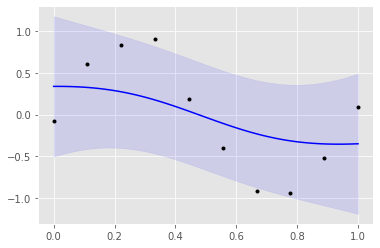

In [6]:
plot_mvn(torch.linspace(0,1,100),f)

In [7]:
model.train()
model.likelihood.train()
opt = torch.optim.LBFGS([{'params':model.parameters()}], max_iter=1000)

In [8]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

In [9]:
import sys
i=0
def closure():
    global i
    output = model(xtrain)
    loss = -mll(output, ytrain)
    opt.zero_grad()
    loss.backward()
    i+=1
    sys.stdout.write('\r%d' % i)
    sys.stdout.flush()
    return loss

opt.step(closure)

17

tensor(1.1138, grad_fn=<NegBackward>)

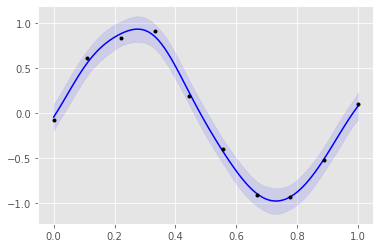

In [10]:
model.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    f = model(torch.linspace(0,1,100))
plot_mvn(torch.linspace(0,1,100),f)

In [18]:
model.initialize()
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-5.1049])),
             ('mean_module.constant', tensor([-0.0337])),
             ('covar_module.raw_outputscale', tensor(-0.1856)),
             ('covar_module.base_kernel.raw_lengthscale',
              tensor([[-1.0892]]))])

In [28]:
model.train()
loss = -mll(model(xtrain), ytrain)

In [29]:
loss.register_hook(lambda grad: print(grad))
loss.backward()

tensor(1.)


In [40]:
model.likelihood.noise_covar.raw_noise.grad

tensor([8.2370e-06])